In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from astropy.table import Table
import pickle
import pandas as pd
import SyntheticData as sd
import Sampler
import json

/home/bepennell/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
data_exp = pickle.load(open("./massive_data/massive_samples_413_qexp.pkl", "rb"))["data"]
sc_cubes_singular = pickle.load(open("./data/2025-12-10-200pc_mdwarf_circular_3plx.pkl", "rb"))

In [4]:
counts = [1000, 2000, 3000, 5000, 10000, 25000, 50000, 100000, 150000, 250000]

In [14]:
indices = [0,5,7,9,12]
working_catalogue = []
relevant_list = ["parallax", "mass", "solution_type"]
for row in data_exp:
    df = dict()
    df["soltype_index"] = indices.index(row["solution_type"])
    for item in relevant_list:
        df[item] = float(row[item])
    working_catalogue.append(df)
working_catalogue = np.array(working_catalogue)

In [ ]:
model_cube = Sampler.create_model_cube((25,15), p_model=(4,1.3), q_model=0.5)
synthsampler = Sampler.popsampler(sc_cubes_singular, working_catalogue, model_cube=model_cube)
grids = synthsampler.assign_grids(working_catalogue, p_range=(1,8), q_range=(0.05,0.5), scale=2)

  0%|          | 0/250000 [00:00<?, ?it/s]

In [29]:
SAMPLE_COUNTS = 5
res = np.zeros((len(counts), 3))

pbar = tqdm(total=len(counts))
for i, count in enumerate(counts):
    temp_res = np.zeros((5,3))
    for j in range(SAMPLE_COUNTS):
        indices = np.random.choice(np.arange(len(working_catalogue)), count)   
        synthdata = working_catalogue[indices]
        working_grids = grids[indices]
        
        synthsampler = Sampler.popsampler(sc_cubes_singular, synthdata, model_cube=model_cube)
        synthsampler.binarity(resolution=1000, grids=working_grids, catalogue=synthdata, scale=1, verbose=False)
        temp_res[j] = synthsampler.fb_estimator()
    res[i] = np.mean(np.array(temp_res), axis=0)
    pbar.update(1)

0it [00:00, ?it/s]

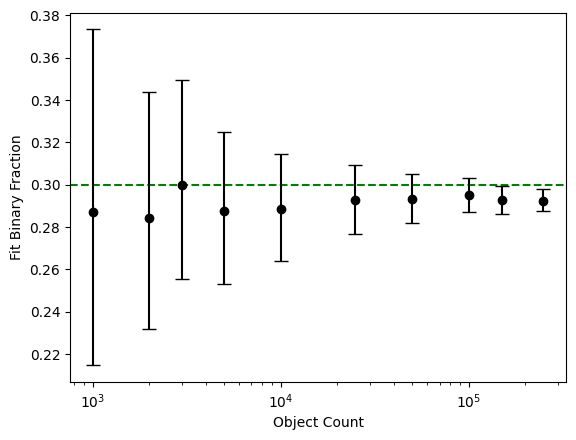

In [34]:
plt.errorbar(counts, res[:,0], yerr=(res[:,2], res[:,1]), fmt='none', capsize=5, ecolor='k', zorder=1);
plt.scatter(counts, res[:,0], marker='o', color='k', zorder=2);
plt.axhline(y=0.3, c="green", linestyle="--", zorder=0);
plt.xlabel("Object Count");
plt.ylabel("Fit Binary Fraction");
plt.xscale('log')